In [1]:
import tensorflow as tf
import keras
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2023-12-16 02:17:35.515301: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
train_image_folder = '/raid/mpsych/OMAMA/DATA/data/train'
train_npz_folder = '/raid/mpsych/OMAMA/DATA/data/2d_resized_512/images'

In [3]:
# Get lists of image and npz files
image_files = [os.path.join(train_image_folder, f) for f in os.listdir(train_image_folder) if f.endswith('.png')]
npz_files = [os.path.join(train_npz_folder, f) for f in os.listdir(train_npz_folder) if f.endswith('.npz')]


In [4]:
# Check if there are any files in the lists
if image_files:
    # Get the first image file in the list
    first_image_file = image_files[0]

    # Read the image using OpenCV
    image = cv2.imread(first_image_file)

    # Get the shape of the image
    image_shape = image.shape
    print(f"Shape of the first image: {image_shape}")
else:
    print("No image files found.")

if npz_files:
    # Get the first npz file in the list
    first_npz_file = npz_files[0]

    # Load the npz file using NumPy
    npz_data = np.load(first_npz_file)

    # Get the shape of the data in the npz file
    npz_data_shape = npz_data['data'].shape
    print(f"Shape of the data in the first npz file: {npz_data_shape}")
else:
    print("No npz files found.")

Shape of the first image: (640, 512, 3)
Shape of the data in the first npz file: (512, 512)


In [5]:
image_files = image_files[:99999]

In [6]:
npz_files = npz_files[:99999]

In [7]:
len(image_files)

99999

In [8]:
len(npz_files)

99999

In [9]:
# Split the dataset (adjust the test_size as needed)
train_files, test_files = train_test_split(list(zip(image_files, npz_files)), test_size=0.3, random_state=42)
val_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)

In [10]:
print(f"Train set length: {len(train_files)}")
print(f"Validation set length: {len(val_files)}")
print(f"Test set length: {len(test_files)}")

Train set length: 69999
Validation set length: 15000
Test set length: 15000


In [11]:
# Displaying a few samples from the splits
print("Train set samples:")
for img_file, npz_file in train_files[:5]:
    print(f"Image File: {img_file}, NPZ File: {npz_file}")

print("Test set samples:")
for img_file, npz_file in test_files[:5]:
    print(f"Image File: {img_file}, NPZ File: {npz_file}")

print("val set samples:")
for img_file, npz_file in val_files[:5]:
    print(f"Image File: {img_file}, NPZ File: {npz_file}")


Train set samples:
Image File: /raid/mpsych/OMAMA/DATA/data/train/sample_60847.png, NPZ File: /raid/mpsych/OMAMA/DATA/data/2d_resized_512/images/10195895820725132694762818055891556958.npz
Image File: /raid/mpsych/OMAMA/DATA/data/train/sample_28616.png, NPZ File: /raid/mpsych/OMAMA/DATA/data/2d_resized_512/images/14822510414339837774385799152326406139.npz
Image File: /raid/mpsych/OMAMA/DATA/data/train/sample_9902.png, NPZ File: /raid/mpsych/OMAMA/DATA/data/2d_resized_512/images/117662734601567944015951467842055389706.npz
Image File: /raid/mpsych/OMAMA/DATA/data/train/sample_14063.png, NPZ File: /raid/mpsych/OMAMA/DATA/data/2d_resized_512/images/100277230214392662382344089241296395354.npz
Image File: /raid/mpsych/OMAMA/DATA/data/train/sample_9000.png, NPZ File: /raid/mpsych/OMAMA/DATA/data/2d_resized_512/images/23497914542737440734565006330973151527.npz
Test set samples:
Image File: /raid/mpsych/OMAMA/DATA/data/train/sample_40876.png, NPZ File: /raid/mpsych/OMAMA/DATA/data/2d_resized_512

Train set samples:


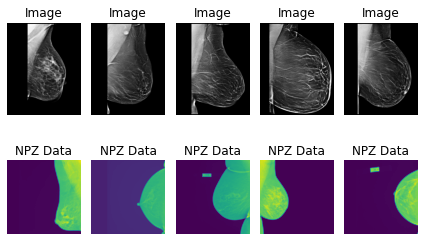

Test set samples:


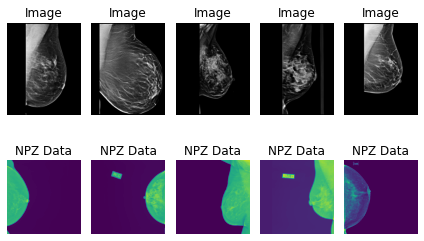

Validation set samples:


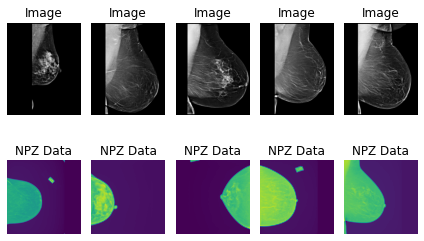

In [12]:
def display_samples(file_list, num_samples=5):
    for i, (img_file, npz_file) in enumerate(file_list[:num_samples]):
        image = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
        npz_data = np.load(npz_file)['data']

        # Plotting image
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title('Image')
        plt.axis('off')

        # Plotting NPZ data
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(npz_data, cmap='viridis')  # Change the colormap as needed
        plt.title('NPZ Data')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display samples from train, test, and validation sets
print("Train set samples:")
display_samples(train_files)

print("Test set samples:")
display_samples(test_files)

print("Validation set samples:")
display_samples(val_files)


In [13]:
img_height = 512
img_width = 512
batch_size = 32

In [40]:
def custom_data_generator(file_list, batch_size, img_height, img_width):
    total_files = len(file_list)
    indices = np.arange(total_files)
    np.random.shuffle(indices)

    while True:
        for i in range(0, total_files, batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_images = []
            batch_npz = []
            batch_labels = []

            for idx in batch_indices:
                img_file, npz_file = file_list[idx]

                # Process image file
                image = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, (img_width, img_height))
                image = np.expand_dims(image, axis=-1)
                image = image / 255.0 
                batch_images.append(image)

                # Process npz file
                with np.load(npz_file, allow_pickle=True) as data:
                    npz = data['data']
                npz = np.expand_dims(npz, axis=-1)
                npz = (npz - npz.min()) / (npz.max() - npz.min())
                batch_npz.append(npz)

                # Assign class labels
                if img_file.endswith('.png'):
                    label = [1, 0]
                elif npz_file.endswith('.npz'):
                    label = [0, 1]
                else:
                    label = [0, 0]
                    
                batch_labels.append(label)
                

            combined_batch = np.concatenate((batch_images, batch_npz), axis=-1)
            print(f"Combined Batch Shape: {combined_batch.shape}")
            yield (combined_batch, np.array(batch_labels))
            print(f"Image Shape: {image.shape}, NPZ Shape: {npz.shape}")
            
            print(f"Image Data Range: Min={image.min()}, Max={image.max()}")
            print(f"NPZ Data Range: Min={npz.min()}, Max={npz.max()}")


Combined Batch Shape: (32, 512, 512, 2)


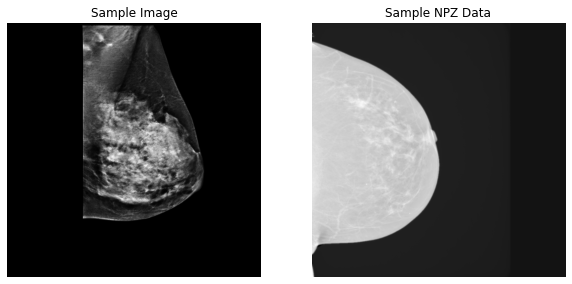

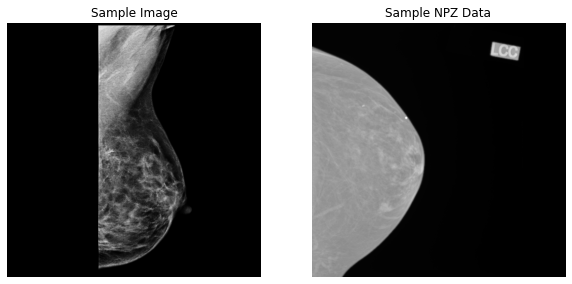

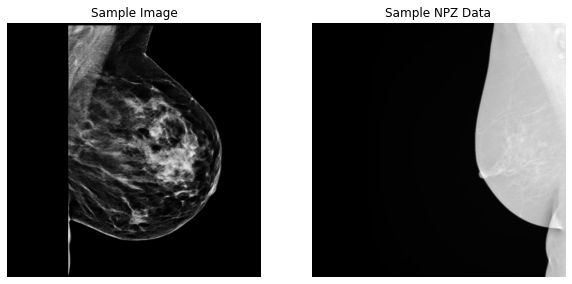

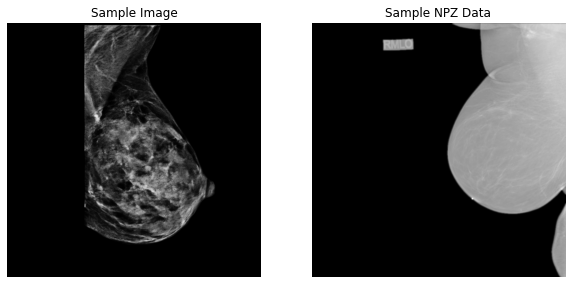

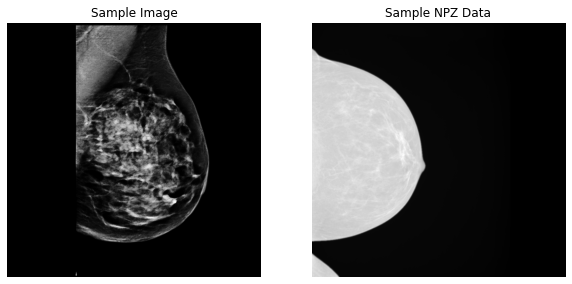

Image Shape: (512, 512, 1), NPZ Shape: (512, 512, 1)
Image Data Range: Min=0.0, Max=0.8901960784313725
NPZ Data Range: Min=0.0, Max=1.0
Combined Batch Shape: (32, 512, 512, 2)


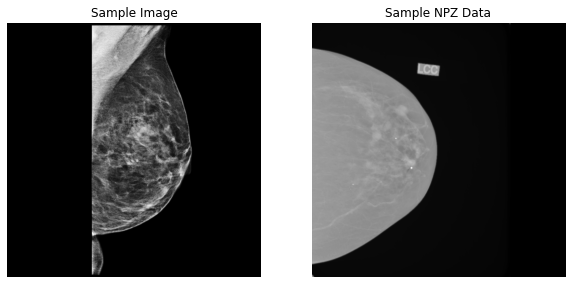

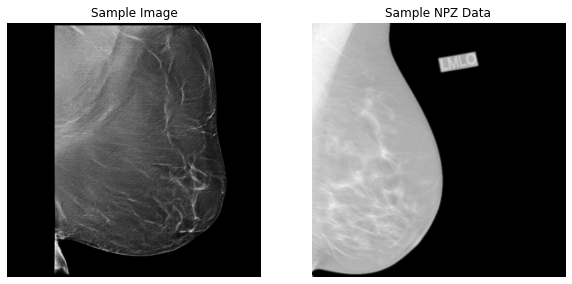

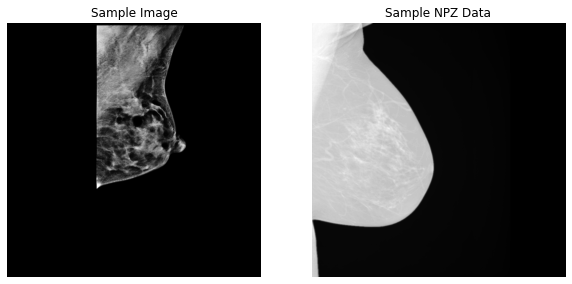

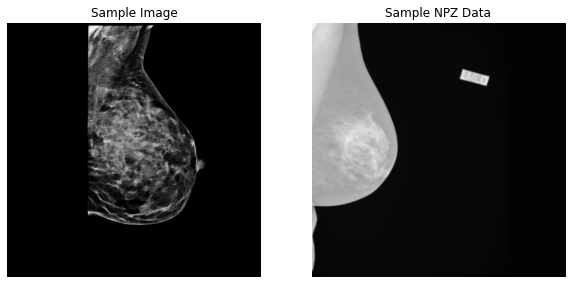

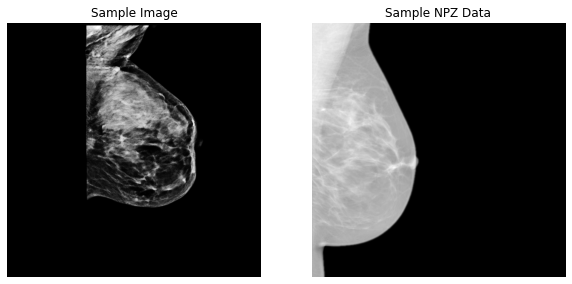

Image Shape: (512, 512, 1), NPZ Shape: (512, 512, 1)
Image Data Range: Min=0.0, Max=1.0
NPZ Data Range: Min=0.0, Max=1.0
Combined Batch Shape: (32, 512, 512, 2)


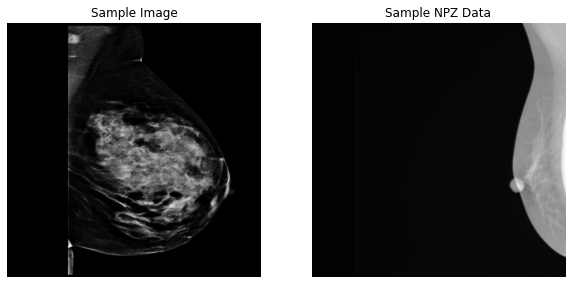

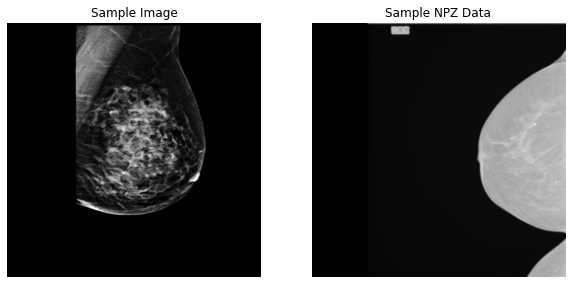

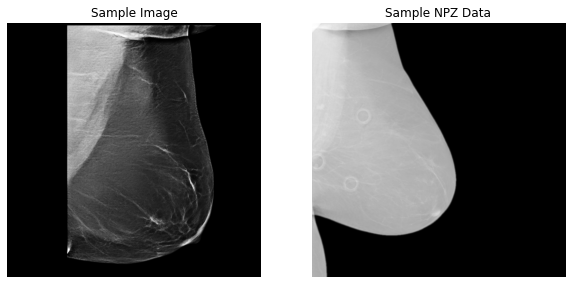

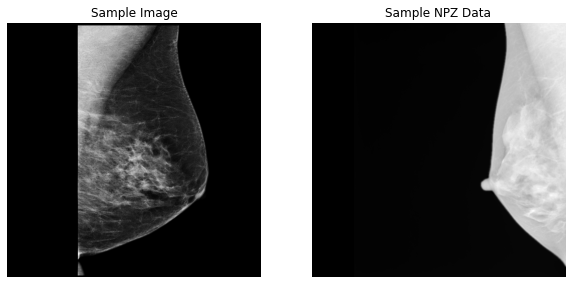

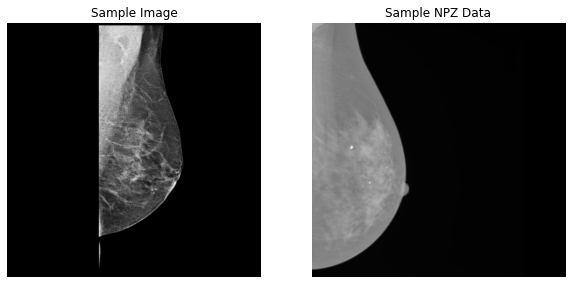

In [15]:
# Create a custom data generator for visualization
visualization_generator = custom_data_generator(train_files, batch_size, img_height, img_width)

# Extract a few batches of data and labels from the generator
num_batches_to_visualize = 3  # Number of batches to visualize
samples_per_batch = 5  # Number of samples per batch to display

for batch_idx in range(num_batches_to_visualize):
    batch_data, batch_labels = next(visualization_generator)
    
    # Display a few samples from the batch
    for sample_idx in range(samples_per_batch):
        sample_image = batch_data[sample_idx, :, :, 0]  # Extracting the image data (assuming it's the first channel)
        sample_npz = batch_data[sample_idx, :, :, 1]    # Extracting the NPZ data (assuming it's the second channel)
        
        # Plot the sample image and NPZ data
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(sample_image, cmap='gray')
        plt.title(f'Sample Image')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(sample_npz, cmap='gray')
        plt.title('Sample NPZ Data')
        plt.axis('off')
        
        plt.show()


In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001, mode='min')

In [17]:
NUMBER_OF_CLASSES = 2

In [41]:
# Create data generators
train_generator = custom_data_generator(train_files, batch_size, img_height, img_width)
val_generator = custom_data_generator(val_files, batch_size, img_height, img_width)
test_generator = custom_data_generator(test_files, batch_size, img_height, img_width)


In [42]:
# Modify the model for deeper architecture
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

# Additional Convolutional layers
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

# Flatten and Dense layers
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(NUMBER_OF_CLASSES, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 510, 510, 32)      608       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 508, 508, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 254, 254, 64)      0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 254, 254, 64)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 252, 252, 128)     73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 126, 126, 128)     0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 126, 126, 128)    

In [43]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer="adadelta",
              metrics=['accuracy'])

In [ ]:
try:
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_files) // batch_size,
        epochs=1,
        validation_data=val_generator,
        validation_steps=len(val_files) // batch_size,
        verbose=1,
        callbacks=[early_stopping]
    )
except Exception as e:
    print("An error occurred during training:", str(e))

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_files) // batch_size)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


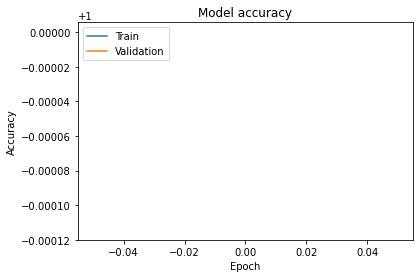

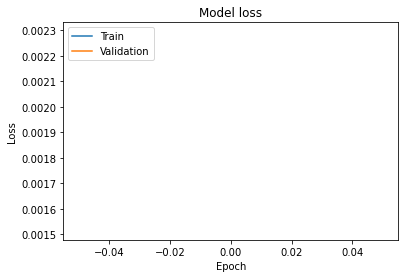

In [22]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Combined Batch Shape: (32, 512, 512, 2)
Sample 1:
Image Shape: (512, 512), NPZ Shape: (512, 512)
Image Max Value: 1.0
NPZ Max Value: 1.0


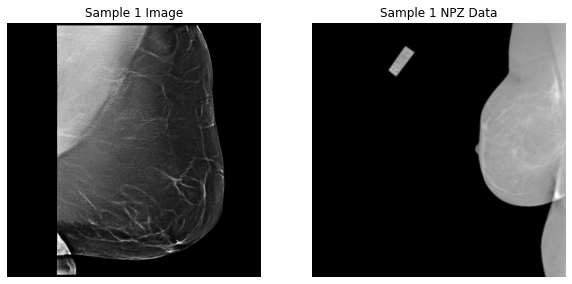

Sample 2:
Image Shape: (512, 512), NPZ Shape: (512, 512)
Image Max Value: 1.0
NPZ Max Value: 1.0


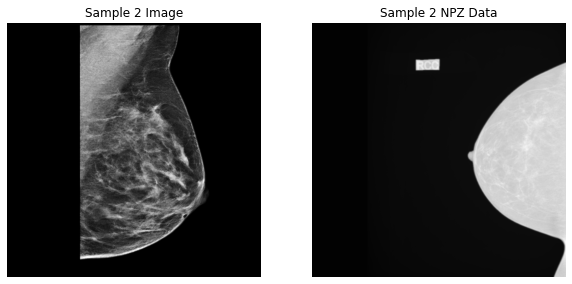

Sample 3:
Image Shape: (512, 512), NPZ Shape: (512, 512)
Image Max Value: 1.0
NPZ Max Value: 1.0


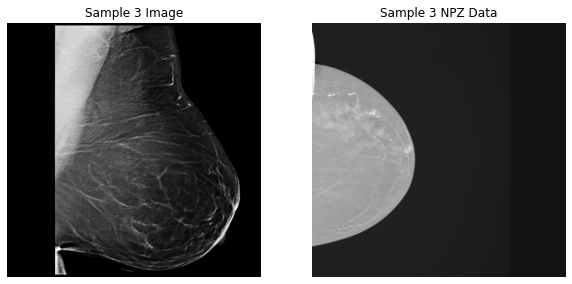

In [23]:
import matplotlib.pyplot as plt

# Create a test generator
test_generator = custom_data_generator(test_files, batch_size, img_height, img_width)

# Get a batch of test data and labels
test_data, test_labels = next(test_generator)

# Display information and plot data for a few samples
num_samples_to_display = 3  # Number of samples to display

for i in range(num_samples_to_display):
    # Extract a sample from the batch
    sample_image = test_data[i, :, :, 0]  # Extracting the image data (assuming it's the first channel)
    sample_npz = test_data[i, :, :, 1]    # Extracting the NPZ data (assuming it's the second channel)
    
    
    # Display shape and max values
    print(f"Sample {i + 1}:")
    print(f"Image Shape: {sample_image.shape}, NPZ Shape: {sample_npz.shape}")
    print(f"Image Max Value: {np.max(sample_image)}")
    print(f"NPZ Max Value: {np.max(sample_npz)}")
    
    # Plot the sample image and NPZ data
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image, cmap='gray')
    plt.title(f'Sample {i + 1} Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(sample_npz, cmap='gray')
    plt.title(f'Sample {i + 1} NPZ Data')
    plt.axis('off')
    
    plt.show()


Image Shape: (512, 512, 1), NPZ Shape: (512, 512, 1)
Image Data Range: Min=0.0, Max=1.0
NPZ Data Range: Min=0.0, Max=1.0
Combined Batch Shape: (32, 512, 512, 2)


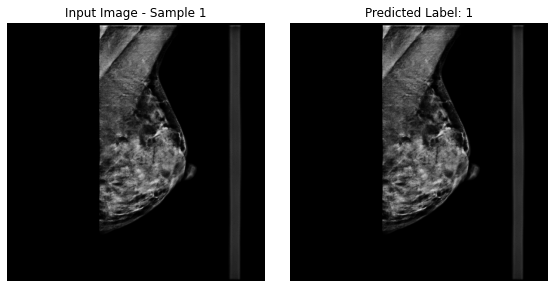

Image Shape: (512, 512, 1), NPZ Shape: (512, 512, 1)
Image Data Range: Min=0.0, Max=0.8745098039215686
NPZ Data Range: Min=0.0, Max=1.0
Combined Batch Shape: (32, 512, 512, 2)


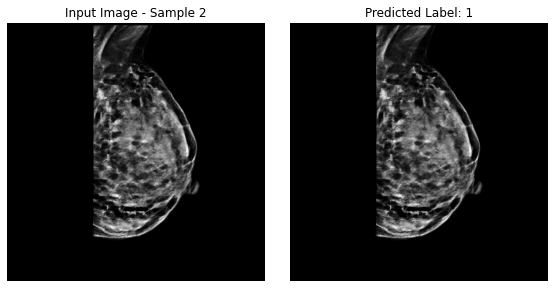

Image Shape: (512, 512, 1), NPZ Shape: (512, 512, 1)
Image Data Range: Min=0.0, Max=1.0
NPZ Data Range: Min=0.0, Max=1.0
Combined Batch Shape: (32, 512, 512, 2)


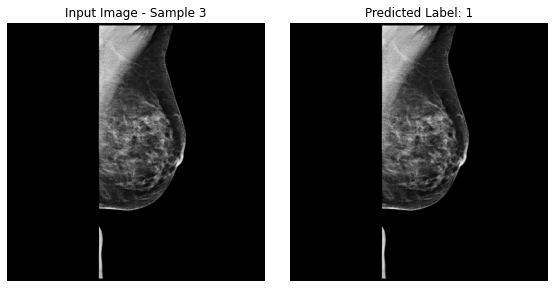

In [56]:
import matplotlib.pyplot as plt

for i in range(3):
    test_sample, test_label = next(test_generator)
    prediction = model.predict(test_sample)
    
    # Select an index from the batch to visualize
    sample_index = 0  # You can change this index to visualize different samples
    
    # Display the input image
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Input Image - Sample {i + 1}")
    plt.imshow(test_sample[sample_index, :, :, 0], cmap='gray')  # Assuming gray-scale images
    plt.axis('off')

    # Display the predicted label
    plt.subplot(1, 2, 2)
    plt.title(f"Predicted Label: {prediction[sample_index].argmax()}")
    plt.imshow(test_sample[sample_index, :, :, 0], cmap='gray')  # Assuming gray-scale images
    plt.axis('off')

    plt.tight_layout()
    plt.show()
